# Model Agnostic - SHAP and ALE

Continue from activity-2, there are some problems we found from using PFI, PDP, and ALE. Those of the limitations are:

- These three methods assume independency between variables, meaning they couldn't catch the interaction effect between variables.
- Eventhough the methods mentioned previously are model-agnostic, they are couldn't perform well for a more complex model like Neural Network, etc.
- Inconsistency of the results

Thus to tackle all of these problems, two methods come in hand: **SHapley Additive exPlanations (SHAP) and Accumulated Local Effects (ALE)**. This will be explained in the each of their section.

In [1]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# import every model we will use for this notebook
from sklearn import metrics, linear_model, tree, discriminant_analysis, ensemble, neural_network, inspection  # inspection to access pfi method
from sklearn.inspection import partial_dependence  # to access the value rather than plotting
from sklearn.inspection import PartialDependenceDisplay

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Description About the Dataset

The dataset used for this is <a href='https://www.kaggle.com/datasets/arashnic/ctrtest'>FIFA Player Dataset</a>, provided by Stefano Leone. Up until this notebooks is in the writing progress, the author has updated the data until FIFA 22. This data set contains:

- FIFA players, starting from FIFA 16 - FIFA 22
- Male and female players

For this data set, I would try to predict the pace of the players based on several attributes available from the data set.

    Data Cleaning and Preparing

In [3]:
# import necessary libraries
import pandas as pd
import os
import glob
import regex as re
  
# use glob to get all the csv files in the folder
# specify file path from path variable
path = '/Users/taufiqurrohman/Documents/ds_marketing_portfolio/interpretable_ml/dataset/fifa-dataset'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df_total = pd.DataFrame()
debug_df = {}
  
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f)

    file_name = f.split("/")[-1]
    fifa_ver = re.search(r"\d+", file_name).group()

    # transformation for the data set
    df['fifa_ver'] = fifa_ver

    if 'female' in file_name:
        df['player_gender'] = 'female'
    else:
        df['player_gender'] = 'male'
    
    # appending the dataset, and create a debug file to check the data
    debug_df[file_name] = f
    df_total = df_total.append(df)

df_total

sofifa_id                                         player_url  \
0         158023  https://sofifa.com/player/158023/lionel-messi/...   
1         188545  https://sofifa.com/player/188545/robert-lewand...   
2          20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
3         190871  https://sofifa.com/player/190871/neymar-da-sil...   
4         192985  https://sofifa.com/player/192985/kevin-de-bruy...   
...          ...                                                ...   
16150     220806  https://sofifa.com/player/220806/ellis-redman/...   
16151     225509  https://sofifa.com/player/225509/aaron-collins...   
16152     201197  https://sofifa.com/player/201197/paul-tisdale/...   
16153     217591  https://sofifa.com/player/217591/piotr-zemlo/1...   
16154     222947  https://sofifa.com/player/222947/tom-davies/15...   

              short_name                            long_name  \
0               L. Messi       Lionel Andrés Messi Cuccittini   
1         R. Lewandowski                   Robert Lewandowski   
2      Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   
3              Neymar Jr        Neymar da Silva Santos Júnior   
4           K. De Bruyne                      Kevin De Bruyne   
...                  ...                                  ...   
16150          E. Redman                         Ellis Redman   
16151         A. Collins            Aaron Graham John Collins   
16152         P. Tisdale                         Paul Tisdale   
16153           P. Żemło                          Piotr Żemło   
16154          T. Davies            Thomas Christopher Davies   

      player_positions  overall  potential    value_eur  wage_eur  age  ...  \
0           RW, ST, CF       93         93   78000000.0  320000.0   34  ...   
1                   ST       92         92  119500000.0  270000.0   32  ...   
2               ST, LW       91         91   45000000.0  270000.0   36  ...   
3              LW, CAM       91         91  129000000.0  270000.0   29  ...   
4              CM, CAM       91         91  125500000.0  350000.0   30  ...   
...                ...      ...        ...          ...       ...  ...  ...   
16150               CB       41         61      20000.0    2000.0   17  ...   
16151               ST       41         50      30000.0    2000.0   17  ...   
16152          CM, CAM       40         40          NaN    2000.0   41  ...   
16153           LM, LB       40         50      15000.0    2000.0   18  ...   
16154               CB       40         49      15000.0    2000.0   22  ...   

        rcb    rb    gk                                    player_face_url  \
0      50+3  61+3  19+3  https://cdn.sofifa.net/players/158/023/22_120.png   
1      60+3  61+3  19+3  https://cdn.sofifa.net/players/188/545/22_120.png   
2      53+3  60+3  20+3  https://cdn.sofifa.net/players/020/801/22_120.png   
3      50+3  62+3  20+3  https://cdn.sofifa.net/players/190/871/22_120.png   
4      69+3  75+3  21+3  https://cdn.sofifa.net/players/192/985/22_120.png   
...     ...   ...   ...                                                ...   
16150    41    40    10  https://cdn.sofifa.net/players/220/806/15_120.png   
16151    31    32    14  https://cdn.sofifa.net/players/225/509/15_120.png   
16152    33    34    10  https://cdn.sofifa.net/players/201/197/15_120.png   
16153  53-3  51-1    12  https://cdn.sofifa.net/players/217/591/15_120.png   
16154    40    39    13  https://cdn.sofifa.net/players/222/947/15_120.png   

                                    club_logo_url  \
0          https://cdn.sofifa.net/teams/73/60.png   
1          https://cdn.sofifa.net/teams/21/60.png   
2          https://cdn.sofifa.net/teams/11/60.png   
3          https://cdn.sofifa.net/teams/73/60.png   
4          https://cdn.sofifa.net/teams/10/60.png   
...                                           ...   
16150  https://cdn.sofifa.net/teams/112254/60.png   
16151  https://cdn.sofifa.net/teams/112254/60.png   
16152     

In [4]:
# dropping duplicate by only showing the latest fifa version

df_total = df_total.sort_values('fifa_ver').drop_duplicates('sofifa_id', keep='last')
df_total = df_total.sort_values('overall', ascending=False).reset_index(drop=True)

df_total

sofifa_id                                         player_url  \
0         158023  https://sofifa.com/player/158023/lionel-messi/...   
1         188545  https://sofifa.com/player/188545/robert-lewand...   
2         233746  https://sofifa.com/player/233746/vivianne-mied...   
3         227316  https://sofifa.com/player/227316/wendie-renard...   
4         227246  https://sofifa.com/player/227246/lucy-bronze/2...   
...          ...                                                ...   
46343     227910  https://sofifa.com/player/227910/liam-gooch/16...   
46344     229852  https://sofifa.com/player/229852/corey-shephar...   
46345     227244  https://sofifa.com/player/227244/danny-clifton...   
46346     220549  https://sofifa.com/player/220549/liam-davies/1...   
46347     201197  https://sofifa.com/player/201197/paul-tisdale/...   

           short_name                       long_name player_positions  \
0            L. Messi  Lionel Andrés Messi Cuccittini       RW, ST, CF   
1      R. Lewandowski              Robert Lewandowski               ST   
2          V. Miedema                Vivianne Miedema               ST   
3           W. Renard       Wéndèleine Thérèse Renard               CB   
4           L. Bronze      Lucia Roberta Tough Bronze           RB, CM   
...               ...                             ...              ...   
46343        L. Gooch                      Liam Gooch               GK   
46344     C. Shephard             Corey John Shephard               CM   
46345      D. Clifton                   Danny Clifton               CM   
46346       L. Davies                     Liam Davies           LM, ST   
46347      P. Tisdale                    Paul Tisdale          CM, CAM   

       overall  potential    value_eur  wage_eur  age  ...   rcb    rb    gk  \
0           93         93   78000000.0  320000.0   34  ...  50+3  61+3  19+3   
1           92         92  119500000.0  270000.0   32  ...  60+3  61+3  19+3   
2           92         93          NaN       NaN   24  ...  52+3  57+3  24+3   
3           92         92          NaN       NaN   30  ...  90+2  80+3  20+3   
4           92         92          NaN       NaN   29  ...  87+3  88+3  21+3   
...        ...        ...          ...       ...  ...  ...   ...   ...   ...   
46343       44         54      40000.0    2000.0   17  ...    24    23    44   
46344       44         56      50000.0    2000.0   17  ...    38    41    13   
46345       44         60      60000.0    2000.0   18  ...    46    47    13   
46346       43         56      25000.0    2000.0   17  ...    34    36    13   
46347       40         40          NaN    2000.0   41  ...    33    34    10   

                                         player_face_url  \
0      https://cdn.sofifa.net/players/158/023/22_120.png   
1      https://cdn.sofifa.net/players/188/545/22_120.png   
2      https://cdn.sofifa.com/players/233/746/22_120.png   
3      https://cdn.sofifa.com/players/227/316/22_120.png   
4      https://cdn.sofifa.com/players/227/246/22_120.png   
...                                                  ...   
46343  https://cdn.sofifa.net/players/227/910/16_120.png   
46344  https://cdn.sofifa.net/players/229/852/16_120.png   
46345  https://cdn.sofifa.net/players/227/244/16_120.png   
46346  https://cdn.sofifa.net/players/220/549/15_120.png   
46347  https://cdn.sofifa.net/players/201/197/15_120.png   

                                    club_logo_url  \
0          https://cdn.sofifa.net/teams/73/60.png   
1          https://cdn.sofifa.net/teams/21/60.png   
2                                             NaN   
3                                             NaN   
4                                             NaN   
...                                           ...   
46343    https://cdn.sofifa.net/teams/1923/60.png   
46344  https://cdn.sofifa.net/teams/112254/60.png   
46345    https://cdn.sofifa.net/teams/1930/60.png   
46346   https://cdn.sofifa.net/teams/15048/60.png   


## Data Preparation Specific for the Model

In [5]:
df = df_total[['sofifa_id', 'short_name', 'pace',                               # pace would be the y-var for this study
               'player_gender', 'age', 'height_cm', 'weight_kg', 'body_type',   # physical traits
               'player_positions', 'preferred_foot', 'work_rate',               # fifa score & attributes, from fia
               'nationality_name', 'fifa_ver']]                                 # other variables

    Cleaning categorical data that only have record below 100 - Nationalities

In [6]:
nation_below_100 = df['nationality_name'].value_counts().loc[lambda x: x < 100].index
print('nationalities with members below 100 members in total:', len(nation_below_100))

nationalities with members below 100 members in total: 120


In [7]:
df = df[~df['nationality_name'].isin(nation_below_100)]
df

sofifa_id      short_name  pace player_gender  age  height_cm  \
0         158023        L. Messi  85.0          male   34        170   
1         188545  R. Lewandowski  78.0          male   32        185   
2         233746      V. Miedema  81.0        female   24        178   
3         227316       W. Renard  68.0        female   30        187   
4         227246       L. Bronze  86.0        female   29        171   
...          ...             ...   ...           ...  ...        ...   
46342     230566        L. Moore   NaN          male   18        180   
46343     227910        L. Gooch   NaN          male   17        181   
46344     229852     C. Shephard  69.0          male   17        173   
46345     227244      D. Clifton  64.0          male   18        178   
46346     220549       L. Davies  59.0          male   17        183   

       weight_kg         body_type player_positions preferred_foot  \
0             72            Unique       RW, ST, CF           Left   
1             81            Unique               ST          Right   
2             65  Normal (170-185)               ST          Right   
3             70       Lean (185+)               CB          Right   
4             67  Normal (170-185)           RB, CM          Right   
...          ...               ...              ...            ...   
46342         73  Normal (170-185)               GK          Right   
46343         65    Lean (170-185)               GK          Right   
46344         69  Normal (170-185)               CM          Right   
46345         66    Lean (170-185)               CM          Right   
46346         70  Normal (170-185)           LM, ST           Left   

           work_rate nationality_name fifa_ver  
0         Medium/Low        Argentina       22  
1        High/Medium           Poland       22  
2           High/Low      Netherlands       22  
3        High/Medium           France       22  
4          High/High          England       22  
...              ...              ...      ...  
46342  Medium/Medium          England       16  
46343  Medium/Medium          England       16  
46344       High/Low            Wales       16  
46345  Medium/Medium          England       16  
46346  Medium/Medium          England       15  

[43988 rows x 13 columns]

In [8]:
# dropping data that has nan value
# seems that pace has it

df = df[~np.isnan(df['pace'])]

    Checking all data format and make a correction

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38930 entries, 0 to 46346
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sofifa_id         38930 non-null  int64  
 1   short_name        38930 non-null  object 
 2   pace              38930 non-null  float64
 3   player_gender     38930 non-null  object 
 4   age               38930 non-null  int64  
 5   height_cm         38930 non-null  int64  
 6   weight_kg         38930 non-null  int64  
 7   body_type         38930 non-null  object 
 8   player_positions  38930 non-null  object 
 9   preferred_foot    38930 non-null  object 
 10  work_rate         38930 non-null  object 
 11  nationality_name  38930 non-null  object 
 12  fifa_ver          38930 non-null  object 
dtypes: float64(1), int64(4), object(8)
memory usage: 4.2+ MB


    Train and Test Split

In [10]:
y = df['pace']
x = df.loc[:, ~df.columns.isin(['sofifa_id', 'short_name', 'pace'])]

x.sample(5)

player_gender  age  height_cm  weight_kg         body_type  \
19883          male   34        184         75  Normal (170-185)   
26819          male   25        181         75  Normal (170-185)   
30955          male   20        175         72  Normal (170-185)   
4639           male   37        168         64     Normal (170-)   
33587          male   23        184         76  Normal (170-185)   

      player_positions preferred_foot      work_rate nationality_name fifa_ver  
19883           RB, CB          Right  Medium/Medium           Poland       19  
26819               ST          Right  Medium/Medium        Argentina       19  
30955               CM          Right  Medium/Medium             Peru       22  
4639           CAM, CM           Left  Medium/Medium        Argentina       18  
33587               CB          Right    Medium/High   Korea Republic       17

In [11]:
from sklearn.model_selection import train_test_split

rand = 42  # define the random state

# create train - test data
# x_train = 85%, y_train = 15% from the splitted data

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.15,
                                                    random_state=rand)

# create validation data set as well
# x_train = 80%, y_val = 20% from the splitted data

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.20, 
                                                  random_state=rand)

    Data Transformation

In [12]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

to_transform = [a for a in x.columns if x[a].dtype == 'object']
to_transform.remove('player_positions')


class CustomFunctionTransformer(FunctionTransformer):
    def __init__(self, func=None, inverse_func=None, validate=False,
                 accept_sparse=False, check_inverse=True,
                 kw_args=None, inv_kw_args=None):
        super().__init__(func=func, inverse_func=inverse_func, validate=validate,
                         accept_sparse=accept_sparse, check_inverse=check_inverse,
                         kw_args=kw_args, inv_kw_args=inv_kw_args)
        self.feature_names_out_ = None

    def transform(self, X):
        result = super().transform(X)
        self.feature_names_out_ = self.func(X).columns.tolist()
        return result

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_


transformer_positions = CustomFunctionTransformer(lambda x: x.str.get_dummies(', '), validate=False)

transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), to_transform),
    (transformer_positions, 'player_positions'),
    remainder='passthrough'
    )

In [13]:
x_train_trf = transformer.fit_transform(x_train)
x_test_trf = transformer.transform(x_test)
x_val_trf = transformer.transform(x_val)

x_cols = transformer.get_feature_names_out()

In [14]:
# checking number of features and the unique values
# whether it matcehs or not

num_onehot = 0

for col in ['player_gender', 'body_type', 'preferred_foot', 'work_rate', 'nationality_name', 'fifa_ver']:
    num = len(x[col].unique())
    num_onehot += num

num_onehot = num_onehot + len(x['player_positions'].str.get_dummies(', ').columns) + 3
num_onehot

111

In [15]:
# checking every shape of the data to be the same
# the shape of x_cols should be the same with x_train_trf

print(x_train_trf.shape)
print(x_test_trf.shape)
print(x_val_trf.shape)
print(len(x_cols))

(26472, 111)
(5840, 111)
(6618, 111)
111


In [16]:
# checking the data for x cols from transformer

print(len(x_cols))
np.random.choice(x_cols, size=10)

111


array(['onehotencoder__fifa_ver_22',
       'onehotencoder__nationality_name_Romania',
       'onehotencoder__nationality_name_Czech Republic',
       'onehotencoder__nationality_name_Finland',
       'onehotencoder__nationality_name_India',
       'onehotencoder__fifa_ver_18',
       'onehotencoder__nationality_name_Northern Ireland',
       'onehotencoder__nationality_name_Mali',
       'onehotencoder__nationality_name_South Africa',
       'onehotencoder__nationality_name_Chile'], dtype=object)

## Model Training

### Neural Network Model

In [17]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

In [18]:
# ensuring the reproducibility
# by setting "rand" variable

os.environ['PYTHONHASHSEED'] = str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

    Model Fitting

In [19]:
import tensorflow as tf

fitted_nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=x_train_trf.shape[1]),
    tf.keras.layers.experimental.preprocessing.Normalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

fitted_nn_model.compile(loss='mean_squared_error',
                        optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0005),
                        metrics=['mse'])

# print summary of each parameter and number of layer
# with nn_model.summary()

fitted_nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 111)               223       
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                7168      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11616 (45.38 KB)
Trainable params: 11393 (44.50 KB)
Non-trainable params: 223 (896.00 Byte)
_________________________________________________________________


In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=200,
                                      min_delta=0.0001,
                                      restore_best_weights=True)

nn_history = fitted_nn_model.fit(x_train_trf.toarray(),
                                 y_train,
                                 epochs=3000,
                                 batch_size=128,
                                 validation_data=(x_val_trf.toarray(), y_val),  # needed for EarlyStopping
                                 verbose=1,
                                 callbacks=[es]  # set EarlyStopping if it has reached some criteria between x_train and x_val
                                 )

Epoch 1/3000
207/207 [==============================] - 0s 1ms/step - loss: 612.2108 - mse: 612.2108 - val_loss: 155.6661 - val_mse: 155.6661
Epoch 2/3000
207/207 [==============================] - 0s 798us/step - loss: 140.4635 - mse: 140.4635 - val_loss: 127.5911 - val_mse: 127.5911
Epoch 3/3000
207/207 [==============================] - 0s 699us/step - loss: 110.7868 - mse: 110.7868 - val_loss: 98.9010 - val_mse: 98.9010
Epoch 4/3000
207/207 [==============================] - 0s 673us/step - loss: 89.9370 - mse: 89.9370 - val_loss: 84.7135 - val_mse: 84.7135
Epoch 5/3000
207/207 [==============================] - 0s 697us/step - loss: 81.9423 - mse: 81.9423 - val_loss: 81.4639 - val_mse: 81.4639
Epoch 6/3000
207/207 [==============================] - 0s 687us/step - loss: 78.8273 - mse: 78.8273 - val_loss: 77.5422 - val_mse: 77.5422
Epoch 7/3000
207/207 [==============================] - 0s 754us/step - loss: 76.4960 - mse: 76.4960 - val_loss: 75.6963 - val_mse: 75.6963
Epoch 8/3000

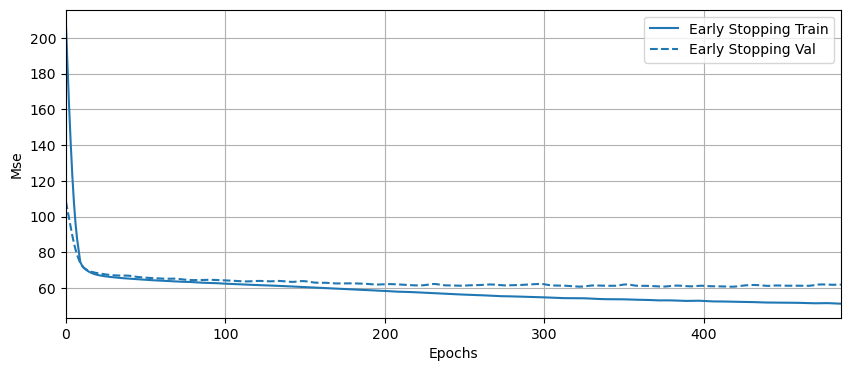

In [21]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# plotting the fitting model process
# epoch to mse

plt.figure(figsize=(10,4))

nn_plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
nn_plotter.plot({'Early Stopping': nn_history}, metric='mse')

plt.show()

    Model Evaluation from Prediction

In [22]:
y_train_nn_pred = fitted_nn_model.predict(x_train_trf.toarray())
y_test_nn_pred = fitted_nn_model.predict(x_test_trf.toarray())

rmse_nn_train = metrics.mean_squared_error(y_train,
                                           y_train_nn_pred,
                                           squared=False)

rmse_nn_test = metrics.mean_squared_error(y_test,
                                          y_test_nn_pred,
                                          squared=False)

r2_nn_test = metrics.r2_score(y_test, y_test_nn_pred)

print('All the score of RNSE train, test, and R2 score:', rmse_nn_train, ',', rmse_nn_test, ',', r2_nn_test)

183/183 [==============================] - 0s 268us/step
All the score of RNSE train, test, and R2 score: 7.350173036308232 , 7.705238979000566 , 0.5224666042233798


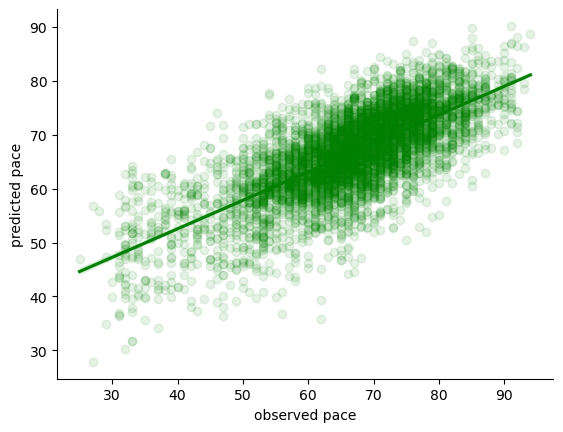

In [23]:
# plot y_test and y_test predict to see how well does the model fits

sns.regplot(x=y_test, y=y_test_nn_pred, color='g', scatter_kws={'alpha': 0.1})
sns.despine()

plt.xlabel('observed pace')
plt.ylabel('predicted pace')

plt.show()

### XGBoost Model

XGBoost is a model that provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The way it works look like this:

1. **Decision Trees:** XGBoost uses a set of decision trees as its base models. A decision tree is a flowchart-like structure where internal nodes represent feature tests, branches represent the outcomes of those tests, and leaf nodes represent the final predictions.

2. **Objective Function:** XGBoost defines an objective function that quantifies the model's performance. In regression tasks, this function is typically mean squared error (MSE), while in classification tasks, it could be log loss or another appropriate metric.

3. **Boosting:** XGBoost uses a boosting technique, where each subsequent tree is trained to correct the mistakes of the previous trees. Boosting iteratively builds the model by adding trees one at a time, focusing on the instances that the previous trees struggled with the most. It assigns higher weights to the misclassified instances, making the subsequent trees pay more attention to them.

4. **Gradient Descent:** XGBoost employs gradient descent optimization to minimize the objective function. It calculates the gradients of the loss function with respect to the predictions and uses this information to update the model's parameters (tree structure and leaf values) in a direction that reduces the loss.

5. **Regularization:** XGBoost includes regularization techniques to prevent overfitting and improve generalization. It applies penalties to the model complexity, such as controlling the tree depth, the number of leaves, or the weights assigned to each leaf. Regularization helps in creating simpler, more robust models.

In [24]:
import xgboost as xgb

    Data Preparation

In [25]:
# XGBoost requires user to store the data in DMatrix object

dtrain = xgb.DMatrix(x_train_trf, label=y_train)
dval = xgb.DMatrix(x_val_trf, label=y_val)
dtest = xgb.DMatrix(x_test_trf, label=y_test)

    Training the Model

- XGBoost use DMatrix, and the way to train the model is totally different from scikit-learn where it follows the syntax of *.fit(x, y)* and *.predict(X)*
- Thus, we're using XGBRegressor wrapper from scikit-learn to be able to follow this syntax
- **REMINDER** that XGBRegressor biggest drawback is that many parameteres of XGBoost is not available within this wrapper

In [26]:
# using the wrapper first

xgb_regressor = xgb.XGBRegressor(max_depth=7,
                                 learning_rate=0.6,
                                 n_jobs=4,
                                 objective='reg:squarederror',
                                 random_state=rand,
                                 n_estimator=50
                                 )

fitted_xgb_model = xgb_regressor.fit(x_train_trf.toarray(), 
                                     y_train,
                                     eval_metric='rmse',
                                     eval_set=[(x_train_trf.toarray(), y_train), (x_val_trf.toarray(), y_val)]
                                     )

[09:42:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-rmse:27.84464	validation_1-rmse:28.00960
[1]	validation_0-rmse:13.42754	validation_1-rmse:13.65782
[2]	validation_0-rmse:9.02414	validation_1-rmse:9.36043
[3]	validation_0-rmse:7.97922	validation_1-rmse:8.36708
[4]	validation_0-rmse:7.71366	validation_1-rmse:8.14602
[5]	validation_0-rmse:7.61471	validation_1-rmse:8.08299
[6]	validation_0-rmse:7.54957	validation_1-rmse:8.02942
[7]	validation_0-rmse:7.42957	validation_1-rmse:7.98051
[8]	validation_0-rmse:7.38993	validation_1-rmse:7.96845
[9]	validation_0-rmse:7.34894	validation_1-rmse:7.95808
[10]	validation_0-rmse:7.29856	validation_1-rmse:7.93762
[11]	validation_0-rmse:7.27537	validation_1-rmse:7.93867
[12]	validation_0-rmse:7.21168	validation_1-rmse:7.92553
[13]	validation_0-rmse:7.18028	validation_1-rmse:7.92843
[14]	validation_0-rmse:7

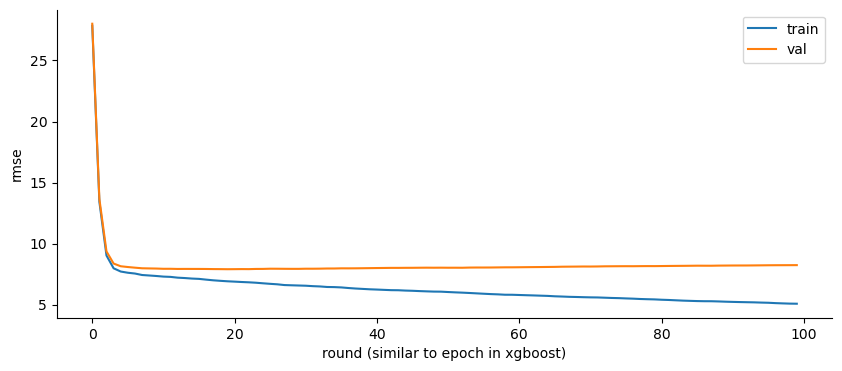

In [27]:
# plotting the fitting model process
# rounds (similar to epoch in xgboost) to rmse

plt.figure(figsize=(10,4))

plt.plot(fitted_xgb_model.evals_result()['validation_0']['rmse'])
plt.plot(fitted_xgb_model.evals_result()['validation_1']['rmse'])

plt.ylabel('rmse')
plt.xlabel('round (similar to epoch in xgboost)')
plt.legend(['train', 'val'])

sns.despine()
plt.show()

    Model Evaluation from Prediction

In [28]:
y_train_xgb_pred = fitted_xgb_model.predict(x_train_trf.toarray())
y_test_xgb_pred = fitted_xgb_model.predict(x_test_trf.toarray())

rmse_xgb_train = metrics.mean_squared_error(y_train,
                                            y_train_xgb_pred,
                                            squared=False)

rmse_xgb_test = metrics.mean_squared_error(y_test,
                                          y_test_xgb_pred,
                                          squared=False)

r2_xgb_test = metrics.r2_score(y_test, y_test_xgb_pred)

print('All the score of RNSE train, test, and R2 score:', rmse_xgb_train, ',', rmse_xgb_test, ',', r2_xgb_test)

All the score of RNSE train, test, and R2 score: 5.077420483499088 , 8.248325862222131 , 0.4527785115139561


In [164]:
y_test_xgb_pred.max()

102.22424

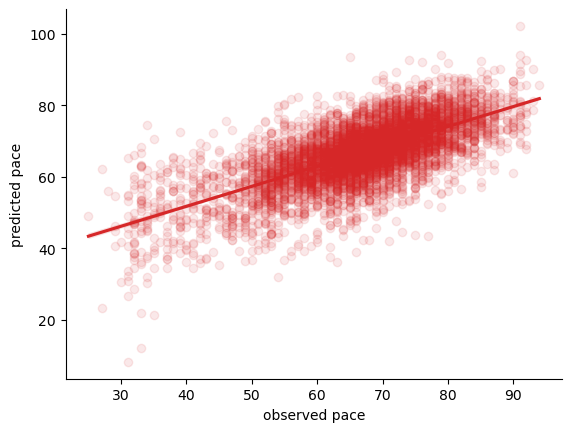

In [29]:
# plot y_test and y_test predict to see how well does the model fits

sns.regplot(x=y_test, y=y_test_xgb_pred, color='tab:red', scatter_kws={'alpha': 0.1})
sns.despine()

plt.xlabel('observed pace')
plt.ylabel('predicted pace')

plt.show()

    Model Evaluation: Built-in Feature Importance Method from XGBoost

- XGBoost will use whatever set of split features to minimize the training loss, so there is no guarantee that all features would be used. 
- Several features here are missing
- Have to look by ourselves which features have been taken out

In [30]:
# look for removed feature from the xgboost

f_list_1 = list(fitted_xgb_model.get_booster().get_score(importance_type = "weight").keys())
f_list_2 = []

for i in range(0, 111):
    f_list_2 = f_list_2 + [f'f{i}']

outersection = list(set(f_list_1) ^ set(f_list_2))
print(outersection)

['f13', 'f1']


In [31]:
# delete from the index
# will be used for the name of the features, as there's no 

x_cols_temp = list(x_cols)

del x_cols_temp[1]
del x_cols_temp[13]

In [32]:
# access the raw feature importance value
# to get the feature names and their importance value

feat_importance = pd.DataFrame(fitted_xgb_model.get_booster().get_score(importance_type = "weight"),  # access the feature importance score from the model
                               index=['raw_importance']).T

feat_importance.index = x_cols_temp
feat_importance.sort_values('raw_importance', ascending=False)

raw_importance
remainder__age                                          1003.0
remainder__weight_kg                                     936.0
remainder__height_cm                                     896.0
onehotencoder__preferred_foot_Left                       208.0
onehotencoder__body_type_Lean (170-185)                  159.0
...                                                        ...
onehotencoder__nationality_name_Bulgaria                   6.0
onehotencoder__nationality_name_Hungary                    6.0
onehotencoder__nationality_name_Czech Republic             5.0
onehotencoder__nationality_name_Côte d'Ivoire              5.0
onehotencoder__nationality_name_Slovenia                   5.0

[109 rows x 1 columns]

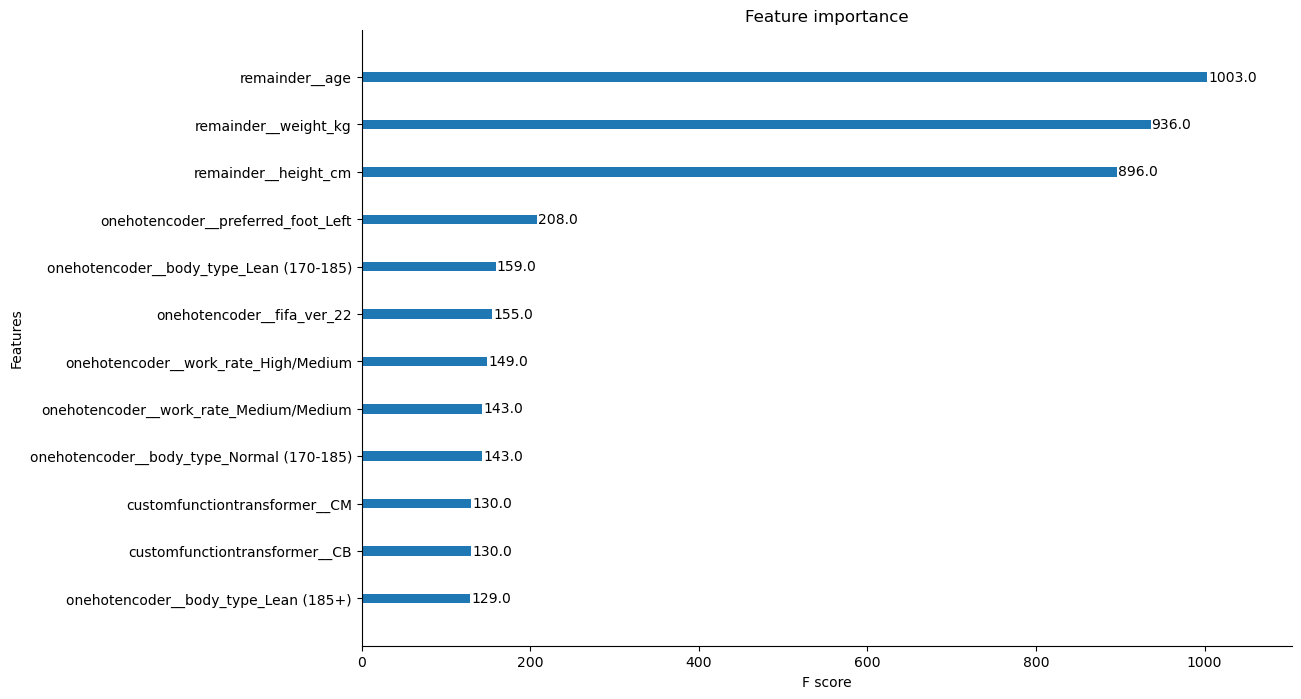

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(fitted_xgb_model, max_num_features=12, ax=ax, importance_type='weight', grid=False)
ax.set_yticklabels(feat_importance.sort_values('raw_importance', ascending=False).index[:12][::-1])

sns.despine()
plt.show()

# Model Interpretation Using SHapley Additive exPlanations (SHAP)

- SHAP stands for SHapley Additive exPlanations. It is a method used in machine learning to explain the predictions made by complex models, such as deep learning models or ensemble models.
- Based on cooperative game theory from economics.
- The main idea behind SHAP is to assign an "importance" value to each feature (or input) in a prediction, indicating how much each feature contributes to the final prediction. It helps us understand the model's decision-making process and provides insights into the factors that influence the outcome.
- To explain the predictions, SHAP considers all possible combinations of features and calculates the contribution of each feature to the prediction outcome. It uses a concept from cooperative game theory called Shapley values to allocate the importance among the features.
- Think of it like a game where each feature is a player, and the prediction outcome is the prize. SHAP measures the impact of each player's presence in the game and determines their share of the prize based on their contribution.
- By using SHAP, we can understand which features have the most significant impact on a prediction and how they interact with each other. This information helps us interpret and trust the predictions made by complex machine learning models.

In computing SHAP value and get on with the interpretation, there are 2 simple steps we need to follow:

1. Initializing explainers
2. Computing SHAP values

In [34]:
import shap

    Initializing Explainer

In [156]:
# explainer for xgboost model

shap_xgb_explainer = shap.TreeExplainer(fitted_xgb_model)
shap_xgb_explainer

In [152]:
# explainer for the neural network model using gradient explainer
# for gradient explainer, we have to feed it a background data set first (sample)

background = x_train_trf[np.random.choice(x_train_trf.shape[0], 150, replace=False)]
print('shape of the background dataset:', background.shape)

# train the model

shap_nn_explainer = shap.GradientExplainer(fitted_nn_model,
                                           background)
shap_nn_explainer

shape of the background dataset: (150, 111)


    Computing SHAP Values

In [165]:
# shap values for xgb model

shap_xgb_values_train = shap_xgb_explainer.shap_values(x_train_trf)
shap_xgb_values_test = shap_xgb_explainer.shap_values(x_test_trf)

print(shap_xgb_values_train.shape)
print(shap_xgb_values_test.shape)

(26472, 111)
(5840, 111)


In [38]:
# shap values for neural network model

shap_nn_values_test = shap_nn_explainer.shap_values(x_test_trf.toarray())

print(type(shap_nn_values_test))
print(shap_nn_values_test[0].shape)

<class 'list'>
(5840, 111)


    Generating SHAP Summary Plots

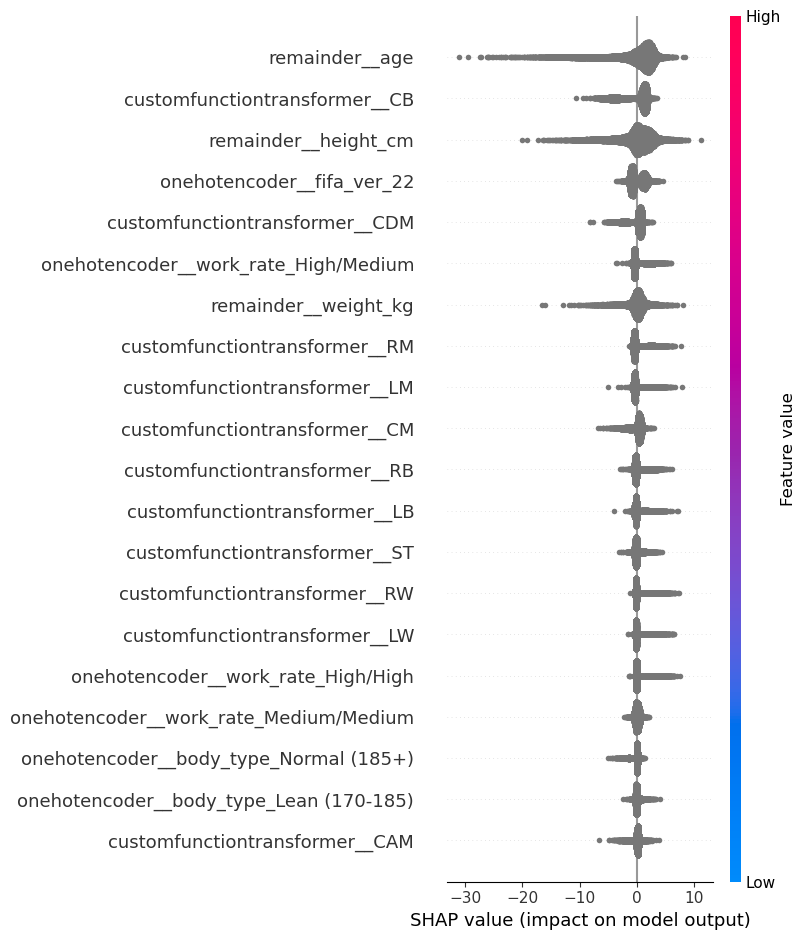

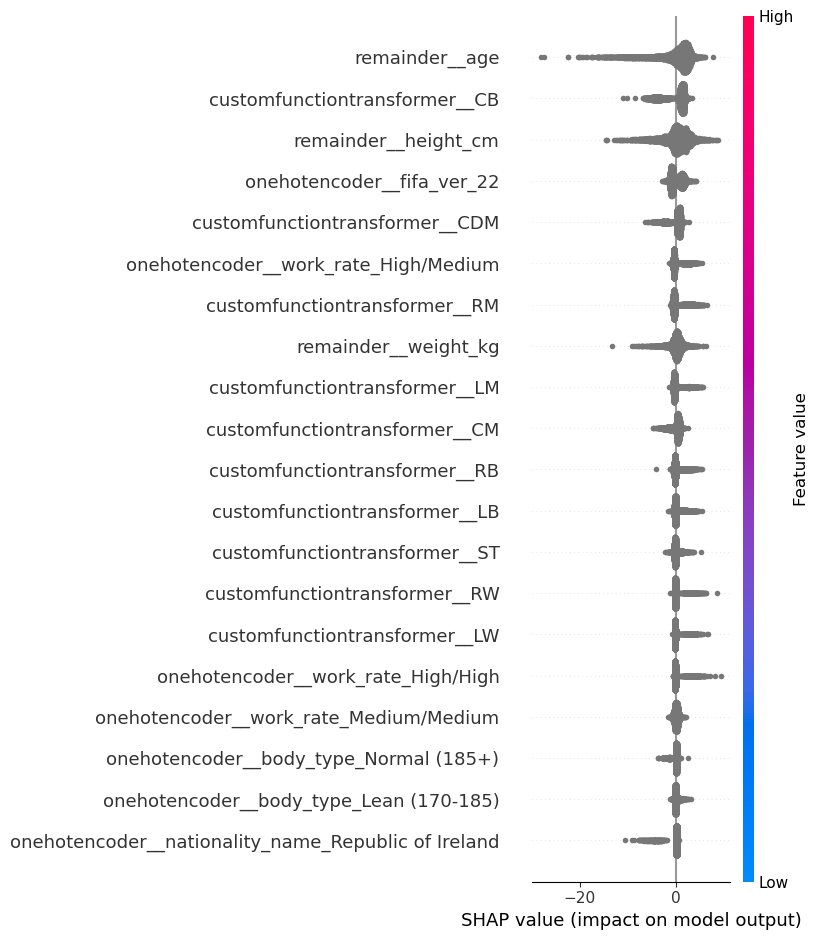

In [39]:
# shap summary plot for xgb
# pass feature names to one 'feature_names' parameter

shap.summary_plot(shap_xgb_values_train, x_train_trf, plot_type='dot', feature_names=x_cols)
shap.summary_plot(shap_xgb_values_test, x_test_trf, plot_type='dot', feature_names=x_cols)

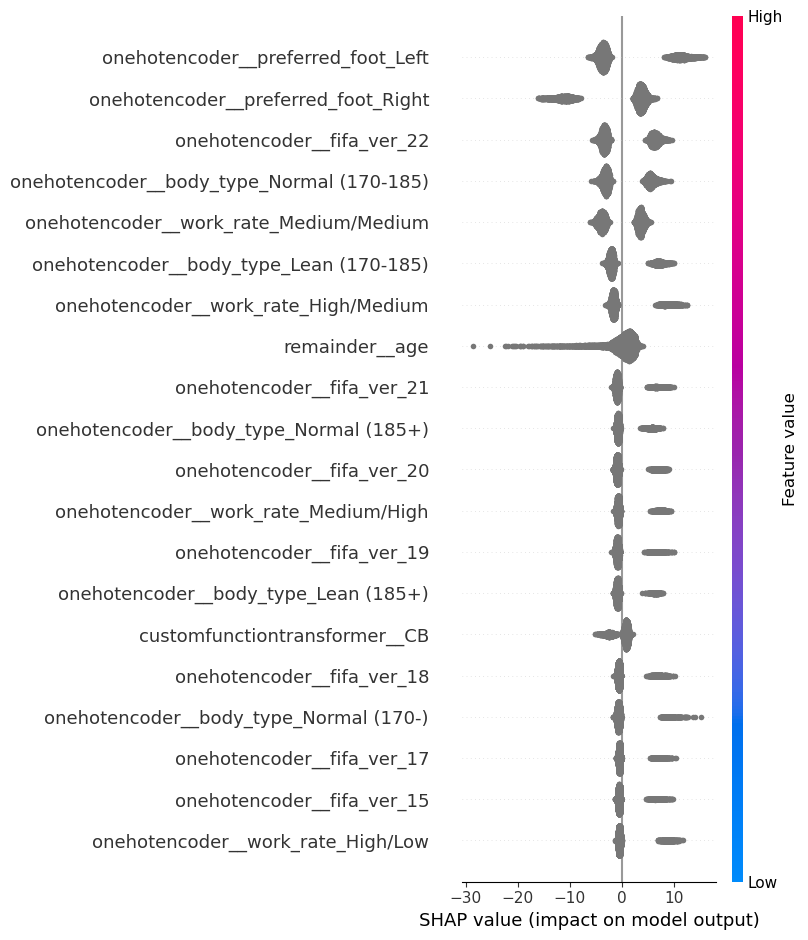

In [40]:
# shap summary plot for neural network
# the distribution looks different because of using normalization

shap.summary_plot(shap_nn_values_test[0], x_test_trf, plot_type='dot', feature_names=x_cols)

## Interactions in Black Box Models

    Exploratory: Plotting Spearman Correlation First

In [41]:
# Take top 5 features from xgboost model

top_feat1 = list(feat_importance.sort_values('raw_importance', ascending=False)[:6].index)
top_feat1.extend(['customfunctiontransformer__CB', 'customfunctiontransformer__CDM', 'pace'])

top_feat1

['remainder__age',
 'remainder__weight_kg',
 'remainder__height_cm',
 'onehotencoder__preferred_foot_Left',
 'onehotencoder__body_type_Lean (170-185)',
 'onehotencoder__fifa_ver_22',
 'customfunctiontransformer__CB',
 'customfunctiontransformer__CDM',
 'pace']

In [42]:
# create transformed dataframe

trf_df = pd.concat([pd.DataFrame.sparse.from_spmatrix(x_train_trf, columns=x_cols), y_train.to_frame().reset_index(drop=True)], axis=1)
temp_df_test = pd.concat([pd.DataFrame.sparse.from_spmatrix(x_test_trf, columns=x_cols), y_test.to_frame().reset_index(drop=True)], axis=1)
temp_df_val = pd.concat([pd.DataFrame.sparse.from_spmatrix(x_val_trf, columns=x_cols), y_val.to_frame().reset_index(drop=True)], axis=1)

trf_df = trf_df.append(temp_df_test).append(temp_df_val)
trf_df

onehotencoder__player_gender_female  onehotencoder__player_gender_male  \
0                                     0.0                                1.0   
1                                     0.0                                1.0   
2                                     0.0                                1.0   
3                                     0.0                                1.0   
4                                     0.0                                1.0   
...                                   ...                                ...   
6613                                  0.0                                1.0   
6614                                  0.0                                1.0   
6615                                  0.0                                1.0   
6616                                  0.0                                1.0   
6617                                  0.0                                1.0   

      onehotencoder__body_type_Lean (170-)  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
6613                                   0.0   
6614                                   0.0   
6615                                   0.0   
6616                                   0.0   
6617                                   0.0   

      onehotencoder__body_type_Lean (170-185)  \
0                                         1.0   
1                                         1.0   
2                                         1.0   
3                                         0.0   
4                                         0.0   
...                                       ...   
6613                                      1.0   
6614                                      0.0   
6615                                      0.0   
6616                                      1.0   
6617                                      0.0   

      onehotencoder__body_type_Lean (185+)  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
6613                                   0.0   
6614                                   0.0   
6615                                   0.0   
6616                                   0.0   
6617                                   1.0   

      onehotencoder__body_type_Normal (170-)  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
6613                                     0.0   
6614                                     0.0   
6615                                     0.0   
6616                                     0.0   
6617                                     0.0   

      onehotencoder__body_type_Normal (170-185)  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           1.0   
4                                           1.0   
...                                         ...   
6613                                        0.0   
6614                                        1.0   
6615                                        1.0   
6616                                        0.0   
6617                                        0.0   

      onehotencoder__body_type_Normal (185+)  \
0                                        0.0   
1                                        0.0   
2               

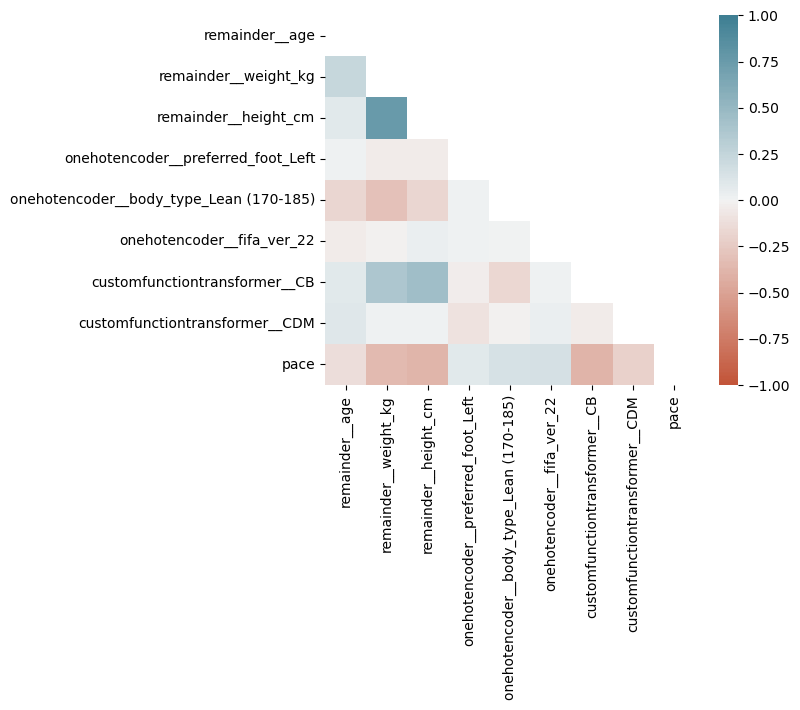

In [43]:
# create heatmap for correlation using spearman's r correlation
# should be only for between continuous variable
# but we'll try to see and compare

import scipy

corrs = scipy.stats.spearmanr(trf_df[top_feat1]).correlation
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corrs, 
                 vmin=-1, vmax=1, center=0, 
                 mask=mask, square=True, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 xticklabels=top_feat1, yticklabels=top_feat1)

In [103]:
# significancy test

from itertools import combinations

comb_feat = list(combinations(top_feat1, 2))
cont_var = ['pace', 'remainder']
corr_dict = {}

for comb in comb_feat:
    
    # if the data is continuous-continuous, then use spearman correlation

    if any(item in comb[0] for item in cont_var) and any(item in comb[1] for item in cont_var):
        corr = scipy.stats.spearmanr(trf_df[comb[0]], trf_df[comb[1]])
        corr_dict[comb] = ['spearman', corr[0], corr[1]]

    # if the data is continuous-dichotonomous, then use biserial correlation

    elif any(item in comb[0] for item in cont_var) or any(item in comb[1] for item in cont_var):
        corr = scipy.stats.pointbiserialr(trf_df[comb[0]], trf_df[comb[1]])
        corr_dict[comb] = ['biserial', corr[0], corr[1]]

    # if the data is dichotonomous-dichotonomous, then use chi square
    # have to create the contingency table first

    else:
        # create contingency table first 
        var1 = trf_df[comb[0]]
        var2 = trf_df[comb[1]]
        observed = np.array([[sum((var1 == 0) & (var2 == 0)), sum((var1 == 0) & (var2 == 1))],
                             [sum((var1 == 1) & (var2 == 0)), sum((var1 == 1) & (var2 == 1))]])

        corr = scipy.stats.chi2_contingency(observed)
        corr_dict[comb] = ['chi2', corr[0], corr[1]]

In [115]:
pd.DataFrame(corr_dict).T.sort_values(2, ascending=False).head(20)

0  \
onehotencoder__body_type_Lean (170-185) onehotencoder__fifa_ver_22                   chi2   
remainder__weight_kg                    onehotencoder__fifa_ver_22               biserial   
onehotencoder__body_type_Lean (170-185) customfunctiontransformer__CDM               chi2   
remainder__height_cm                    customfunctiontransformer__CDM           biserial   
remainder__weight_kg                    customfunctiontransformer__CDM           biserial   
remainder__age                          onehotencoder__preferred_foot_Left       biserial   
onehotencoder__fifa_ver_22              customfunctiontransformer__CB                chi2   
onehotencoder__preferred_foot_Left      onehotencoder__fifa_ver_22                   chi2   
                                        onehotencoder__body_type_Lean (170-185)      chi2   
                                        customfunctiontransformer__CB                chi2   
remainder__height_cm                    onehotencoder__fifa_ver_22               biserial   
remainder__weight_kg                    onehotencoder__preferred_foot_Left       biserial   
remainder__height_cm                    onehotencoder__preferred_foot_Left       biserial   
onehotencoder__fifa_ver_22              customfunctiontransformer__CDM               chi2   
customfunctiontransformer__CB           customfunctiontransformer__CDM               chi2   
remainder__age                          onehotencoder__fifa_ver_22               biserial   
onehotencoder__preferred_foot_Left      pace                                     biserial   
remainder__age                          remainder__height_cm                     spearman   
                                        customfunctiontransformer__CB            biserial   
                                        customfunctiontransformer__CDM           biserial   

                                                                                         1  \
onehotencoder__body_type_Lean (170-185) onehotencoder__fifa_ver_22                1.328089   
remainder__weight_kg                    onehotencoder__fifa_ver_22               -0.008063   
onehotencoder__body_type_Lean (170-185) customfunctiontransformer__CDM            2.641612   
remainder__height_cm                    customfunctiontransformer__CDM            0.008645   
remainder__weight_kg                    customfunctiontransformer__CDM            0.011676   
remainder__age                          onehotencoder__preferred_foot_Left         0.01175   
onehotencoder__fifa_ver_22              customfunctiontransformer__CB             7.397529   
onehotencoder__preferred_foot_Left      onehotencoder__fifa_ver_22               13.559085   
                                        onehotencoder__body_type_Lean (170-185)  18.898515   
                                        customfunctiontransformer__CB             38.41817   
remainder__height_cm                    onehotencoder__fifa_ver_22                0.037275   
remainder__weight_kg                    onehotencoder__preferred_foot_Left       -0.037694   
remainder__height_cm                    onehotencoder__preferred_foot_Left       -0.037917   
onehotencoder__fifa_ver_22              customfunctiontransformer__CDM           58.480144   
customfunctiontransformer__CB           customfunctiontransformer__CDM           83.951629   
remainder__age                          onehotencoder__fifa_ver_22               -0.052558   
onehotencoder__preferred_foot_Left      pace                                      0.069576   
remainder__age                          remainder__height_cm                       0.08059   
                                        customfunctiontransformer__CB             0.083688   
                                        customfunctiontransformer__CDM            0.087629   

                                                                                        2  
onehotencoder__body_type_Lean (170-185) onehotencoder__fifa_ver_22 

In [117]:
pd.DataFrame(corr_dict).T.sort_values(1).head(20)

0  \
customfunctiontransformer__CB      pace                                     biserial   
remainder__height_cm               pace                                     spearman   
remainder__weight_kg               pace                                     spearman   
                                   onehotencoder__body_type_Lean (170-185)  biserial   
customfunctiontransformer__CDM     pace                                     biserial   
remainder__age                     onehotencoder__body_type_Lean (170-185)  biserial   
remainder__height_cm               onehotencoder__body_type_Lean (170-185)  biserial   
remainder__age                     pace                                     spearman   
                                   onehotencoder__fifa_ver_22               biserial   
remainder__height_cm               onehotencoder__preferred_foot_Left       biserial   
remainder__weight_kg               onehotencoder__preferred_foot_Left       biserial   
                                   onehotencoder__fifa_ver_22               biserial   
remainder__height_cm               customfunctiontransformer__CDM           biserial   
remainder__weight_kg               customfunctiontransformer__CDM           biserial   
remainder__age                     onehotencoder__preferred_foot_Left       biserial   
remainder__height_cm               onehotencoder__fifa_ver_22               biserial   
onehotencoder__preferred_foot_Left pace                                     biserial   
remainder__age                     remainder__height_cm                     spearman   
                                   customfunctiontransformer__CB            biserial   
                                   customfunctiontransformer__CDM           biserial   

                                                                                   1  \
customfunctiontransformer__CB      pace                                    -0.403326   
remainder__height_cm               pace                                     -0.38939   
remainder__weight_kg               pace                                    -0.352342   
                                   onehotencoder__body_type_Lean (170-185) -0.276466   
customfunctiontransformer__CDM     pace                                    -0.184654   
remainder__age                     onehotencoder__body_type_Lean (170-185) -0.168206   
remainder__height_cm               onehotencoder__body_type_Lean (170-185) -0.142884   
remainder__age                     pace                                    -0.132342   
                                   onehotencoder__fifa_ver_22              -0.052558   
remainder__height_cm               onehotencoder__preferred_foot_Left      -0.037917   
remainder__weight_kg               onehotencoder__preferred_foot_Left      -0.037694   
                                   onehotencoder__fifa_ver_22              -0.008063   
remainder__height_cm               customfunctiontransformer__CDM           0.008645   
remainder__weight_kg               customfunctiontransformer__CDM           0.011676   
remainder__age                     onehotencoder__preferred_foot_Left        0.01175   
remainder__height_cm               onehotencoder__fifa_ver_22               0.037275   
onehotencoder__preferred_foot_Left pace                                     0.069576   
remainder__age                     remainder__height_cm                      0.08059   
                                   customfunctiontransformer__CB            0.083688   
                                   customfunctiontransformer__CDM           0.087629   

                                                                                   2  
customfunctiontransformer__CB      pace                                          0.0  
remainder__height_cm               pace                                          0.0  
remainder__weight_kg               pace                                          0.0  
                                   on

    Interaction Using SHAP Dependence SHAP Dependence Plot

- SHAP dependence plot is a plot between the SHAP value for a feature on the y-axis and the feature values on the x-axis
- Showing the values represented in the x-axis, and the impact on the outcome changes on the y-axis.
- Can also show the interaction using **'interaction_index'** parameter in **shap.dependence_plot()** method

Importance thing to take a note:

- The shap value here shows **estimate of the contribution of each feature to the prediction made by the model for a specific instance.**
- So the scale of Y might be different, as it is only estimate of the contribution

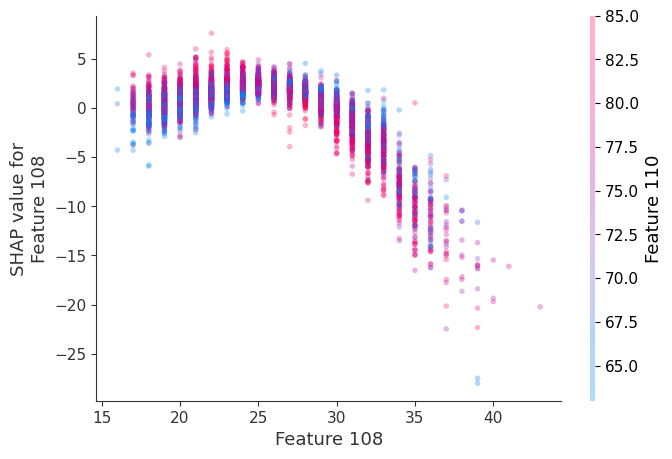

In [142]:
# plot age to pace
# with interaction of weight in kg
# using shap.dependence_plot()

idx_xval = int(np.where(x_cols == 'remainder__age')[0])
idx_inter = int(np.where(x_cols == 'remainder__weight_kg')[0])

shap.dependence_plot(idx_xval,                                  # pass the index or name of the column from x_test
                     shap_xgb_values_test,                      # pass y value here
                     x_test_trf.toarray(),                      # pass x value here
                     interaction_index=idx_inter,               # put any variable you want to investigate for interaction
                     alpha=0.3                                  # set transparency of the interaction variable
                     )

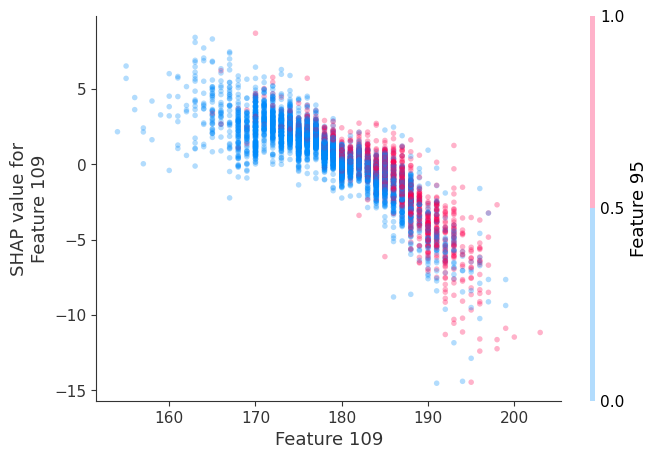

In [143]:
# height to cb position
# to see a clearer interaction

idx_xval = int(np.where(x_cols == 'remainder__height_cm')[0])
idx_inter = int(np.where(x_cols == 'customfunctiontransformer__CB')[0])

shap.dependence_plot(idx_xval,                                  # pass the index or name of the column from x_test
                     shap_xgb_values_test,                      # pass y value here
                     x_test_trf.toarray(),                      # pass x value here
                     interaction_index=idx_inter,               # put any variable you want to investigate for interaction
                     alpha=0.3                                  # set transparency of the interaction variable
                     )

## SHAP Force Plot

SHAP force plot provides an individualized explanation for a specific prediction by showing the contribution of each feature to the prediction outcome.

    Visualization for Multiple Data Points

In [197]:
from IPython.display import HTML

# sampling the data
# as it is interactive, would be much faster if we taking the sample of it

sample_test_size = 0.1
sample_test_idx = np.random.choice(x_test_trf.shape[0],
                                   math.ceil(x_test_trf.shape[0] * sample_test_size),
                                   replace=False
                                   )

# initiate shap.initjs()
# as shap.force_plot is an interactive plot

shap.initjs()
fp = shap.force_plot(shap_xgb_explainer.expected_value,
                     shap_xgb_values_test[sample_test_idx],
                     x_test_trf.toarray()[sample_test_idx]
                     )

# to make the background white
# convert shap force to html object

HTML(f"<div style='background-color:White;'>{shap.getjs() + fp.html()}</div>")

    Visualization for Only One Point

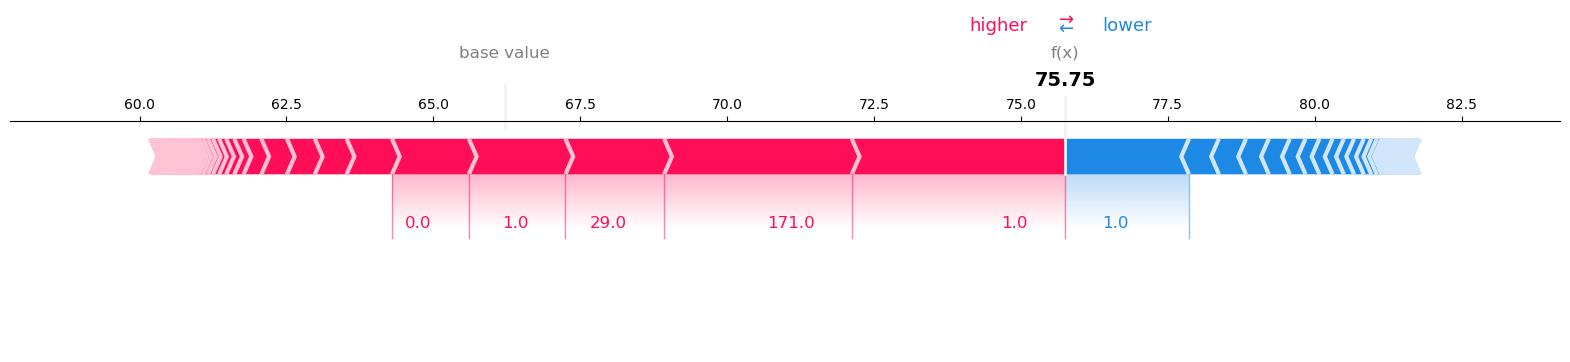

In [200]:
# only one data point
# with this one, we can pass matplotlib parameter, thus making it processes faster

shap.force_plot(shap_xgb_explainer.expected_value,
                shap_xgb_values_test[1],
                x_test_trf.toarray()[1],
                matplotlib=True  # matplotlib parameter, makes it faster
                )

# Accumulated Local Effect (ALE) Plot

- ALE is another method to calculate feature importance of explanatory variables over the dependent variable
- ALE works by calculating the average marginal effect of a feature over a specified range of its values 
- It provides a smoothed approximation of the relationship between a feature and the model's prediction
- Unbiased: Meaning that they don't have an assumption that features are uncorrelated, resulting in **isolating one feature's effect from others**

In the terms of differences between ALE and SHAP are that:

- ALE provides local interpretability while SHAP could be used for both local and global interpretation
- ALE focuses on individual feature effects and does not explicitly consider feature interactions, while SHAP explicitly considers feature interactions

## ALE in Action

- Using ALEPython library -> requires data in Pandas format
- **Cannot be used for NN model** -> workaround with creating wrapper class

In [210]:
# training data with dataframe first
# as ale needs the data in forms of 

onehotencoder__player_gender_female  onehotencoder__player_gender_male  \
0                                     0.0                                1.0   
1                                     0.0                                1.0   
2                                     0.0                                1.0   
3                                     0.0                                1.0   
4                                     0.0                                1.0   
...                                   ...                                ...   
5835                                  0.0                                1.0   
5836                                  0.0                                1.0   
5837                                  0.0                                1.0   
5838                                  0.0                                1.0   
5839                                  0.0                                1.0   

      onehotencoder__body_type_Lean (170-)  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
5835                                   0.0   
5836                                   0.0   
5837                                   0.0   
5838                                   0.0   
5839                                   0.0   

      onehotencoder__body_type_Lean (170-185)  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         1.0   
4                                         0.0   
...                                       ...   
5835                                      1.0   
5836                                      0.0   
5837                                      0.0   
5838                                      0.0   
5839                                      0.0   

      onehotencoder__body_type_Lean (185+)  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      1.0   
...                                    ...   
5835                                   0.0   
5836                                   0.0   
5837                                   0.0   
5838                                   1.0   
5839                                   0.0   

      onehotencoder__body_type_Normal (170-)  \
0                                        1.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
5835                                     0.0   
5836                                     0.0   
5837                                     1.0   
5838                                     0.0   
5839                                     0.0   

      onehotencoder__body_type_Normal (170-185)  \
0                                           0.0   
1                                           1.0   
2                                           1.0   
3                                           0.0   
4                                           0.0   
...                                         ...   
5835                                        0.0   
5836                                        1.0   
5837                                        0.0   
5838                                        0.0   
5839                                        1.0   

      onehotencoder__body_type_Normal (185+)  \
0                                        0.0   
1                                        0.0   
2               

    Plotting One Feature at a Time

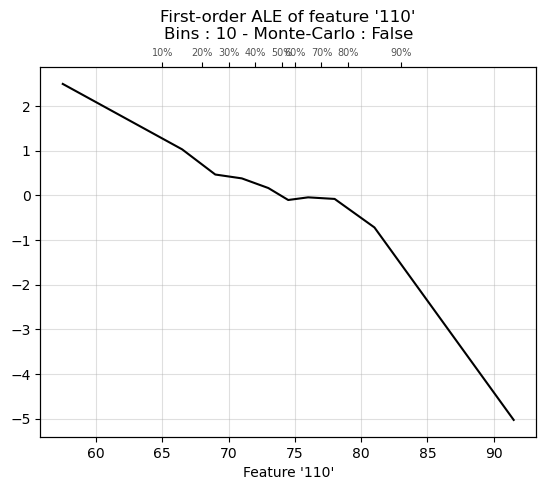

<Axes: title={'center': "First-order ALE of feature '110'\nBins : 10 - Monte-Carlo : False"}, xlabel="Feature '110'">

In [220]:
from alepython import ale_plot

# transform the data to pandas dataframe first
x_test_df = pd.DataFrame.sparse.from_spmatrix(x_test_trf)

# plotting ale

idx_feat = int(np.where(x_cols == 'remainder__weight_kg')[0])

ale_plot(fitted_xgb_model,  # model we want to look at
         x_test_df,         # x variable
         features=idx_feat  # which feature
         )

    Plotting Two Features at a Time

For plotting interaction between two variables.

error: (mx>kx) failed for hidden mx: regrid_smth:mx=1

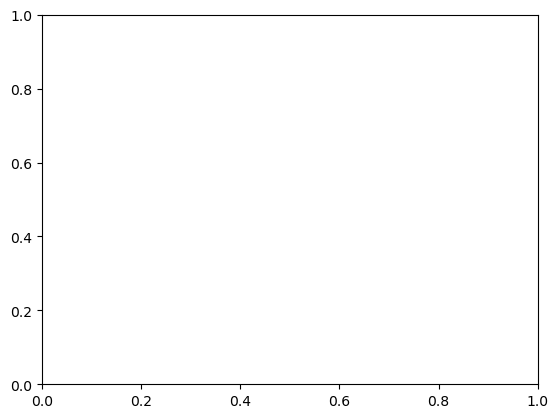

In [239]:
from alepython import ale_plot

# transform the data to pandas dataframe first
x_test_df = pd.DataFrame.sparse.from_spmatrix(x_test_trf)

# plotting ale

idx_feat1 = int(np.where(x_cols == 'customfunctiontransformer__CB')[0])
idx_feat2 = int(np.where(x_cols == 'remainder__height_cm')[0])  

ale_plot(fitted_xgb_model,                       # model we want to look at
         x_test_df,                              # x variable
         features=[idx_feat1, idx_feat2],        # specify the feature interaction here
         )

# INVESTIGATE MORE -> (mx>kx) failed for hidden mx: regrid_smth:mx=1
# for the code syntax, open the book page 229

# Global Surrogates

- In the context of machine learning, global surrogate models refer to a **white-box model that you train with the black-box models prediction**
- No need any fancy libraries, we can use any white-box models

The steps are as follow:

1. Fit the surrogates **using the black-box model prediction as y**
2. Evaluating surrogate model
3. Investigate the estimator for each variables from the white-box model

## Fitting the Surrogate Model

    Fitting Neural Network Prediction with Decision Tree

In [242]:
dt_model = tree.DecisionTreeRegressor(max_depth=7, random_state=rand)
fitted_dt_surrogate = dt_model.fit(x_train_trf,
                                   y_train_nn_pred)

y_train_dt_pred = fitted_dt_surrogate.predict(x_train_trf)
y_test_dt_pred = fitted_dt_surrogate.predict(x_test_trf)

In [247]:
print('y_train:', y_train_dt_pred)
print('y_test:', y_test_dt_pred)

y_train: [76.36038547 69.85364226 75.18104981 ... 58.19724202 69.85364226
 71.88338095]
y_test: [69.85364226 76.36038547 69.85364226 ... 76.36038547 60.50564831
 52.07154202]


    Fitting Neural Network Prediction with RuleFit

Important! RuleFit requires data in the format of numpy float.

In [260]:
from rulefit import RuleFit

rf_model = RuleFit(max_rules=150,
                   rfmode='regress',
                   random_state=rand,
                   tree_size=8
                   )

fitted_rf_surrogate = rf_model.fit(x_train_trf.toarray().astype(float),
                                   y_train_nn_pred.astype(float)
                                   )

y_train_rf_pred = fitted_rf_surrogate.predict(x_train_trf.toarray().astype(float))
y_test_rf_pred = fitted_rf_surrogate.predict(x_test_trf.toarray().astype(float))

In [261]:
print('y_train:', y_train_rf_pred)
print('y_test:', y_test_rf_pred)

y_train: [75.62884201 70.7584178  76.05770821 ... 69.53342392 69.9084733
 69.95816005]
y_test: [70.31269219 76.14183388 67.90229857 ... 80.97067936 60.37594082
 57.25495826]


## Evaluating Surrogate Model to the Black-Box Model 

- It's like, measuring how good is the surrogate model replicating the black-box model prediction
- If the prediction of surrogate model is too far, or too overfitting, then you shouldn't use the surrogate either

In [270]:
# run rmse both for test and train data to see whether the model overfits

rmse_dt_nn_train = metrics.mean_squared_error(y_train_nn_pred, y_train_dt_pred, squared=False)
rmse_dt_nn_test = metrics.mean_squared_error(y_test_nn_pred, y_test_dt_pred, squared=False)
r2_dt_nn_test = metrics.r2_score(y_test_nn_pred, y_test_dt_pred)

# print all metrics

print('rmse for train data:', rmse_dt_nn_train)
print('rmse for test data:', rmse_dt_nn_test)
print('r2 for test data:', r2_dt_nn_test)

rmse for train data: 4.145129142334609
rmse for test data: 4.274774980787246
r2 for test data: 0.7252100144836642


In [271]:
# run rmse both for test and train data to see whether the model overfits

rmse_rf_nn_train = metrics.mean_squared_error(y_train_nn_pred, y_train_rf_pred, squared=False)
rmse_rf_nn_test = metrics.mean_squared_error(y_test_nn_pred, y_test_rf_pred, squared=False)
r2_rf_nn_test = metrics.r2_score(y_test_nn_pred, y_test_rf_pred)

# print all metrics

print('rmse for train data:', rmse_rf_nn_train)
print('rmse for test data:', rmse_rf_nn_test)
print('r2 for test data:', r2_rf_nn_test)

rmse for train data: 3.289557496353362
rmse for test data: 3.313395476210825
r2 for test data: 0.8349099369824902


**The result shows that it fits better on RuleFit model, thus we will go with RuleFit model.**

## Investigate Each Estimator

In [274]:
# investigate each estimator using rulefit model

rulefit_df = fitted_rf_surrogate.get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0]
rulefit_df.sort_values(by='importance', ascending=False)

rule    type      coef  \
16                                          feature_16  linear  5.401322   
104                                        feature_104  linear  3.920531   
14                                          feature_14  linear  6.012536   
100                                        feature_100  linear  3.162397   
211                                 feature_108 > 31.5    rule -2.959800   
..                                                 ...     ...       ...   
197  feature_108 <= 36.5 & feature_109 <= 184.5 & f...    rule  0.157058   
151  feature_100 > 0.5 & feature_95 <= 0.5 & featur...    rule -0.062812   
166  feature_98 <= 0.5 & feature_95 <= 0.5 & featur...    rule  0.027802   
152  feature_16 <= 0.5 & feature_109 <= 184.5 & fea...    rule  0.009518   
91                                          feature_91  linear  0.002603   

      support  importance  
16   1.000000    2.047670  
104  1.000000    1.344512  
14   1.000000    1.232754  
100  1.000000    1.092196  
211  0.134758    1.010669  
..        ...         ...  
197  0.008364    0.014304  
151  0.018587    0.008484  
166  0.068773    0.007036  
152  0.084572    0.002648  
91   1.000000    0.000742  

[115 rows x 5 columns]

    NOTE

Surrogate model's findings can **only be conclusive about the original model**, not about the data used to train the model.